# Image Classification and Object Detection using Imageai

Computer vision is one of the most prominent technologies used in human computer interface today. Appplications include autonomous driving, security, interpretating language, and more. In this tutorial, we will use the [imageai](https://imageai.readthedocs.io/en/latest/index.html#) library to perform several computer vision tasks:

    image classification
    object detection in image
    object detection in video
    
And finally, we will see how to train a model using data from the [mnist](http://yann.lecun.com/exdb/mnist/) dataset.
    
Imageai is a relatively new library, and built as an easy, prepackaged tool for developers to implement simple computer vision tasks. As such, it includes pretrained image models that can classify and detect common objects, which requires no additional training needed from the user. New models can be trained as well, but this is not the focus of this library. Due to its recent development, the documentation and functionality of imageai is relatively limited, but this also makes the package simpler to learn. 


# Installing Libraries

This library has several dependencies, listed in the requirements.txt file. Install these, as well as imageai, before running the tutorial:

```
$ pip3 install tensorflow
$ pip3 install numpy==1.16.4
$ pip3 install scipy
$ pip3 install opencv-python
$ pip3 install pillow
$ pip3 install matplotlib
$ pip3 install h5py
$ pip3 install keras
$ pip3 install imageai --upgrade
```
Note that we use numpy==1.16.4, since more recent versions may not be compatible with tensorflow. 

Let's import:

In [42]:
from imageai.Prediction import ImagePrediction
from imageai.Detection import ObjectDetection
from imageai.Detection import VideoObjectDetection
from PIL import Image
from IPython.display import display
from IPython.display import Video
import os

# Image Classification

Classification is the task of predicting the subject of an image. For example, if an image is of a dog, the model should output a high percentage probability of labeling the image as 'dog'. Imageai provides pretrained models that have been trained on the [imagenet 1000](http://www.image-net.org/) dataset, capable of predicting 1000 objects (which may be enough for many general computer vision applications).

To predict an image, simply download any image from the internet or from a dataset. For this tutorial, we will predict the subject of this image that was downloaded from a simple google image search:

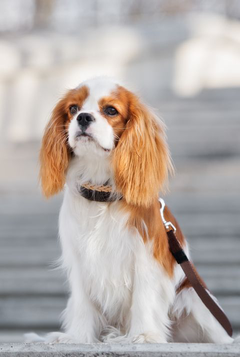

In [13]:
# input images stored in filepath input/image.jpg
img = Image.open('input/dog1.jpg')
img = img.resize((img.size[0] // 2, img.size[1] // 2), Image.ANTIALIAS)
display(img)

We begin by defining a neural model type and loading in the pretrained model. The imageai library uses *squeezenet, resnet, inceptionv3*, and *densenet* neural models. In this tutorial, we will use the [inceptionv3](https://cloud.google.com/tpu/docs/inception-v3-advanced) by Google. 

In [18]:
# define image classifier using inceptionv3 model
predictor = ImagePrediction()
predictor.setModelTypeAsInceptionV3()
predictor.setModelPath('models/inceptionv3.h5')

# load model
predictor.loadModel()

Now we can use this model to run classification on our test image. The `predictImage` function takes in our image filepath, as well as `result_count` which sets how many different predictions to output. It returns two arrays, one containing predictions, and the other containing the probability of the corresponding prediction. 

In [19]:
# run single image classification
single_pred, single_prob = predictor.predictImage('input/dog1.jpg', result_count=3)

Printing each value after zipping the two output lists, we can see the model's predictions for this image.

In [20]:
# print single image results
for each_pred, each_prob in zip(single_pred, single_prob):
    print(each_pred , ": " , each_prob)

Blenheim_spaniel :  99.99873638153076
Japanese_spaniel :  0.0007204715984698851
Sussex_spaniel :  0.00027238470465817954


It appears that there is a very high probability that this image is of a blenheim spaniel breed of dog, with much lower likelihood of the next two predictions. A Google search of 'blenheim spaniel' confirms that this is indeed the correct prediction!



# Multiple Image Classification

Imageai also includes a module for predicting multiple images at once. Applications of computer vision rarely include predicting only a single image, so we will also run multiple prediction. For the sake of readability, we will run the model on only a few images in this tutorial (also downloaded from Google searches). 

We can use the same classification model that we loaded in earlier, `predictor`. Let's begin by creating an array of image filepaths to input to our predictor:

In [22]:
# load image files into array
classify_images = []
classify_images.append('input/cat1.jpg')
classify_images.append('input/kayak1.jpg')
classify_images.append('input/tokyo1.jpg')

Before we run predictions, let's see what each image looks like:

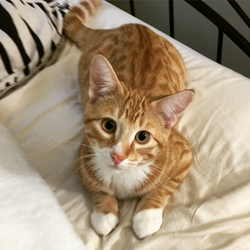

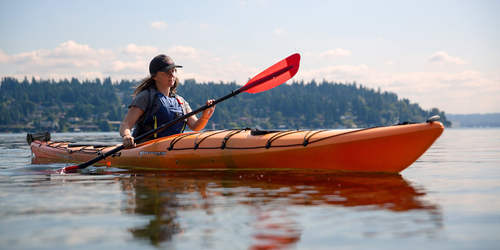

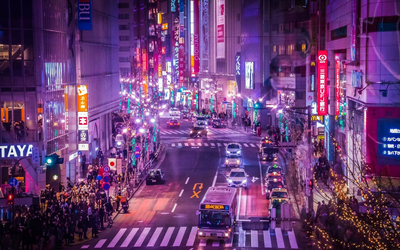

In [34]:
# print images
for each_img in classify_images:
    imgx = Image.open(each_img)
    w, h = imgx.size
    imgx = imgx.resize((int(w*(250/h)), 250), Image.ANTIALIAS)
    display(imgx)

Multiple prediction is similar to single image prediction. The `predictMultipleImages` function takes in an array of image filepaths, as well as `result_count_per_image` which sets how many different predictions to output for each of the images. Instead of an array of predictions and probabilities, this function returns a single list of dictionaries, each corresponding to a single image. The dictionaries have two keys: `'predictions'` and `'percentage_probabilities'`, each one associated with lists as we've seen before.

Let's run the predictions on the image array and print out the results for each image, keeping result count at 3:

In [35]:
# run multiple image classification
multi_pred = predictor.predictMultipleImages(classify_images, result_count_per_image=3)

# print resuts for all images
for image_res in multi_pred:
    image_pred, image_prob = image_res["predictions"], image_res["percentage_probabilities"]
    for i in range(len(image_pred)):
        print(image_pred[i] , " : " , image_prob[i])
    print("-----------------------")

tiger_cat  :  98.95532131195068
tabby  :  1.0188357904553413
Egyptian_cat  :  0.022908988466951996
-----------------------
canoe  :  76.8865168094635
paddle  :  23.0539470911026
catamaran  :  0.009997429879149422
-----------------------
stage  :  49.745696783065796
altar  :  36.413583159446716
church  :  3.9488717913627625
-----------------------


As you can see, the model outputs 3 predictions along with probabilities just as we want. The first image is easy to classify, as it only contains a single subject clearly recognizable as a cat, thus we have a 98.96% probability. The second image is tougher to predict, as it contains multiple objects, and can be classified in a variety of ways. The model does pretty well, outputting a 76.89% probability of a canoe. The second highest classification, with 23.05% probability, is a paddle, which also appears in the image. The last image is extremely tough as it contains several different objects, and represents a scene rather than a singe subject. It takes a guess with only 49.75% probability that it might be a stage. 

These last two examples lead us to our next topic, object classification, which can mitigate the problems we see here. 

# Object Detection

Object detection differs from image classification in that it attempts to find multiple subjects in a single image and classifies each of them, rather than classify the entire image under one subject. This is particularly useful for situations we just saw, where there are multiple objects in a single image. In many applications of computer vision, object detection is also more useful since the real world often includes multiple objects in a singe camera frame. 

Imageai includes detection tools as well, trained on the [MS COCO](http://cocodataset.org/#home) dataset, and can recognize 80 common objects (other specific objects will require more training on top of the pretrained models). 

For our tutorial, we will run object detection on a few complex images, once again downloaded from Google images, including a few of the ones that our classification model did not do as well on:

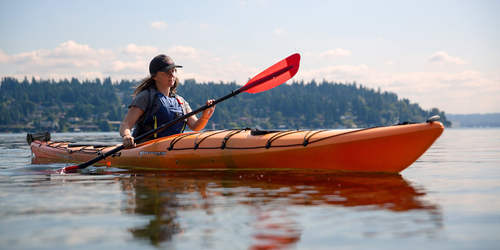

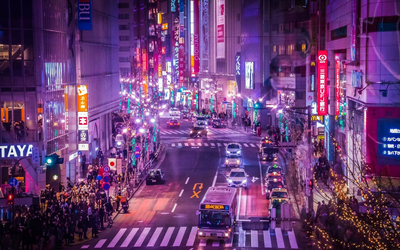

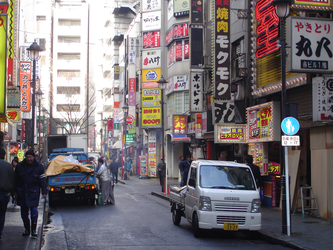

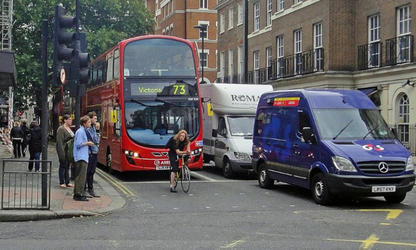

In [36]:
# load image files into array
detect_images = []
detect_images.append('input/kayak1.jpg')
detect_images.append('input/tokyo1.jpg')
detect_images.append('input/tokyo2.jpg')
detect_images.append('input/image.jpeg')

# print images
for each_img in detect_images:
    imgx = Image.open(each_img)
    w, h = imgx.size
    imgx = imgx.resize((int(w*(250/h)), 250), Image.ANTIALIAS)
    display(imgx)

First let's load in a pretrained model for object detection. Imageai detection models include *retinanet, yolov3,* and *tinyyolov3*. We will use [yolov3](https://pjreddie.com/darknet/yolo/).

In [38]:
# define object detector using yolov3 model
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("models/yolo.h5")

# load model
detector.loadModel()

Lets use the `detectObjectsFromImage` functions to detect objects in each of the images. The function takes in an image filepath, as well as an output image filepath, where it will store an edited version of the image where each object is outlined (we just changed the filepath from `input/imagefile` to `output/imagefile`). It can also take in a `minimum_percentage_probability` so that it only outputs an object if it recognizes it with a minimum probability. Here we set it to 50. 

Lets run predictions on every image in our array and print the results:

In [40]:
for each_img in detect_images:
    
    # run object detection
    detections = detector.detectObjectsFromImage(input_image=each_img, 
                                                 output_image_path=('output/'+each_img[6:]), minimum_percentage_probability=50)
    # print results
    for each_object in detections:
        print(each_object["name"] , ": " , each_object["percentage_probability"] )
        
    print("-----------------------")


boat :  92.07506775856018
person :  99.18721318244934
-----------------------
traffic light :  56.79846405982971
bus :  95.94641923904419
car :  50.37943124771118
car :  56.45766258239746
car :  57.015037536621094
car :  74.83092546463013
car :  80.99579215049744
car :  81.4424455165863
car :  87.48980760574341
car :  91.72396063804626
car :  94.26001310348511
-----------------------
car :  83.1432044506073
car :  94.41637992858887
person :  51.55843496322632
person :  64.26092386245728
person :  68.919438123703
person :  84.08018946647644
person :  90.7621443271637
person :  95.93999981880188
person :  96.94961309432983
person :  96.95806503295898
person :  97.34681844711304
person :  99.61751699447632
-----------------------
traffic light :  57.40170478820801
truck :  90.85505604743958
bus :  96.51609063148499
bus :  99.83268976211548
person :  73.49355816841125
person :  89.48699235916138
person :  93.7789797782898
person :  98.92157912254333
person :  99.69531297683716
------------

Here we see that for each image it has detected multiple objects within the image. The first image definitely includes a person and a boat with high probability, and we can see two cars and many people in image three. Overall, the object detection model detects objects pretty well. 

Lets take a closer look at how the model allows us to visualize the detections. It generates a new images with each of the detections clearly labeled. We saved these in the *output* folder when we ran the detection function. 

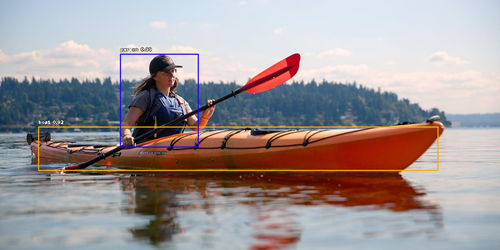

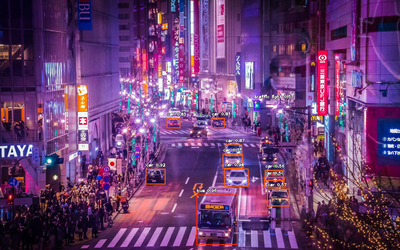

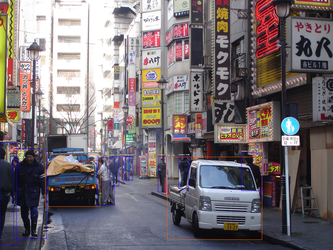

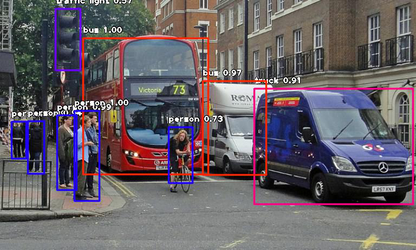

In [41]:
# load image files into array
output_images = []
output_images.append('output/kayak1.jpg')
output_images.append('output/tokyo1.jpg')
output_images.append('output/tokyo2.jpg')
output_images.append('output/image.jpeg')

# print output images
for each_img in output_images:
    imgx = Image.open(each_img)
    w, h = imgx.size
    imgx = imgx.resize((int(w*(250/h)), 250), Image.ANTIALIAS)
    display(imgx)

Notice the boxes drawn around each object as well as the label and probability. This makes it extremely easy to present results and visualize the output. 

# Object Detection in Video

Beside images, this library also provides functions for detecting objects in videos. There are many practical applications of video object analysis, including in security cameras, autonomous vehicles, and even alerts for package delivery. The video object detection is actually very similar to image detection, breaking down each video into a series of frames and running detection on each of them. 

This means that running object detection on video takes longer and outputs much more data, and so for this tutorial, we will test it on a short video clip and examine in detail the data it produces. In longer video analysis, such as security footage, the data may have to be preprocessed and some frames selected in order to avoid an impractical runtime. Our test clip is a few seconds of security camera footage:

In [43]:
Video('input/security-cam.mp4')

Let's begin by loading in a video detection model, once using the yolov3 model.

In [44]:
# define video object detector
vid_detector = VideoObjectDetection()
vid_detector.setModelTypeAsYOLOv3()
vid_detector.setModelPath("models/yolo.h5")

# load model
vid_detector.loadModel()

Before running the video detector, we will define a helper function to print the data outputted by the detector for each second of the video. This function takes in four arguments that are passed in by the detection function, the second of video that the data is from, an array of dictionaries mapping frame number to objects in the frame, an array of dictionaries mapping frame number to number of objects in the frame, and a dictionary mapping each unique object to the number of instances in the frame. We will use some of the data available to construct a similar output to what we have seen: objects detected per second and the percentage probability.

In [45]:
# helper function to output analysis of video per second
def sec_analysis(sec, objects_detected_per_frame, object_counts, objects_detected_per_second):
    obj_dict = {}
    print("SECOND: ", sec)
    
    # input obj classification from highest probability frame into dictionary
    for lst in objects_detected_per_frame:
        for obj in lst:
            if obj['name'] not in obj_dict:
                obj_dict[obj['name']] = obj['percentage_probability']
            else:
                if obj['percentage_probability'] > obj_dict[obj['name']]:
                    obj_dict[obj['name']] = obj['percentage_probability']
    
    for k,v in obj_dict.items():
        print(k, ': ', v)
                    
    print("\n--------------------------\n")

Now let's run `detectObjectsFromVideo`, which takes in the video filepath, and an output filepath in which it will store a modified video (like the modified images from the last section). Optionally, it can also take in the frames per second it will analyze (we will use 20 to improve runtime), a minimum probability (set to 50 here), and our helper function to output data in a readable format.

In [50]:
# run video object detection
video = vid_detector.detectObjectsFromVideo(input_file_path="input/security-cam.mp4",
                            output_file_path="output/security-cam-new", 
                            frames_per_second=20, minimum_percentage_probability=50, 
                            per_second_function=sec_analysis)

SECOND:  1
bus :  67.55232214927673
car :  92.12148785591125
person :  99.60927367210388
truck :  72.76459336280823
suitcase :  87.95366883277893

--------------------------



Here, since we set the frames/sec to 20, we only analyzed enough frames to generate one second of total analyzed video. However, we can still see that the model detected both the truck and the car in the background, as well as the delivery person and what it guesses is a suitcase (actually the delivered package). 

Let's display the output video to see what the model produced (outputs are in .avi format by default):

In [56]:
from IPython.display import HTML
Video('output/security-cam-new.avi')

(If the video does not display, you can always find it manually in the *output* folder)

# Application: Training a Classification Model to Predict Handwriting

In order to show advanced applications of this library, we will train out own model to classify handwriting. However, training a model requires a GPU, so we will run this portion of the tutorial on a Google colab cloud server. You can view this part of the tutorial either on [Google colab](https://colab.research.google.com/drive/12EIGc1DrBV9F5fZCQATNr7DiuIqxJNCt) or a local [jupyter notebook](./image_classification_train.ipynb). 



**Note: running the training model on a local machine will take many hours or days**

# End

Congrats! You've learn the basics of the imageai library, enough to classify images, detect objects in image or video, and even train your own classification models!